In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime
import time
import multiprocessing  as mp
from itertools import product

from keras.models import Sequential,Model
from keras.layers import *#Dense, Input, Concatenate, Lambda,LSTM,Dropout,Layer,Flatten
from keras.layers import ConvLSTM2D,BatchNormalization,TimeDistributed,MaxPooling3D
from keras.optimizers import RMSprop, Adam
from keras import optimizers
from keras.utils.vis_utils import plot_model
import keras.losses as kl 
import pydot

from keras import optimizers
import keras

import pickle
''
import tensorflow as tf

import itertools

import sys
import warnings
import os
#from tqdm import tqdm
os.chdir('/gneven/Desktop/ETH/Sem2/Projeckt/Pyhton/')
from scipy.interpolate import UnivariateSpline
from functions import * 

idx = pd.IndexSlice


tf.config.threading.set_intra_op_parallelism_threads(6)
tf.config.threading.set_inter_op_parallelism_threads(6)

In [2]:
num_next_time = 3
before_dt = 20

dt = 30

startTime = int(6.5*3600)
endTime = int(10.5*3600 )

ncoeur = 8

allfile = os.listdir('data/data2/Times/')



Data = get_time_data('data/data2/Times/'+allfile[0])

for str in allfile[1:]:
       Data = pd.concat([Data,get_time_data('data/data2/Times/'+str)])
    
Data = Data.loc[Data['datum_nach'].dt.dayofweek < 5,:]
#delete depot run
Data = Data[~Data['fw_lang'].str.contains('DEP|Einfahrt|Ausfahrt')]

# Data = Data[Data['linie'] == 32]

Data['ID'] = 100000000*Data['richtung']+ 10000*Data['linie']+Data['halt_diva_nach']

Data['kurs'] = 100*Data['linie'] + Data['kurs']


# ## Selection
# ### Stops
# Select the 3 lateness (travel time, stops and total ) for every stops every 30s, if no new bus came, the last one is kept. It was first thought to take as time step the updating of the bus lateness, but as we now have multiple bus it does not work.
DataO = Data[Data['datum_nach'] == Data['datum_nach'].unique()[0]]
#
occurence_of_line = DataO.loc[(DataO['soll_ab_von'] < endTime)&(DataO['soll_ab_von'] > startTime),'linie'].value_counts()
DelLine = occurence_of_line[occurence_of_line<300].index
Data = Data[~Data['linie'].isin(DelLine)]
# Or it would have too many NAN and useless line, we delete every line with less
# then 300 occurences

Studied_line = 32

Data = Data[((Data['soll_ab_von'] < endTime + 1000)&(Data['soll_ab_von'] > startTime - 1000))]

Data = Data.sort_values(by= ['kurs','ist_ab_nach'])


i = 0
for day in Data['datum_nach'].unique():

    if i == 0:
        splitData = list([Data.loc[Data['datum_nach'] == day,:]])
    else:
        splitData.append(Data.loc[Data['datum_nach'] == day,:])
    i+=1
    
with open('Data_line_all.pickle','wb') as f:
    pickle.dump(Data['kurs'].unique(),f)
    

In [18]:
# Data['kurs'].unique()[170:183] line 32

test = np.array([[[1,2,3,4],[5,6,7,8]],[[9,10,11,12],[13,14,15,16]]])
test = test.reshape(test.shape[0]*test.shape[1]*test.shape[2])
test.reshape(2,2,4)

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [10]:

with open('Data_line.pickle','wb') as f:
    pickle.dump(Data['kurs'].unique(),f)
    


In [11]:
t1 = time.time()
Data_d = splitData[0]


    

def features_selector(Data_d):

#for i in [1]:
    day = Data_d['datum_nach'].unique().astype('int')

#
#    colname = [np.repeat(Data['ID'].unique(),3),np.resize(['Delta_stops','Delta_trip','Tot_lat'
#                                                             ],3*Data['ID'].unique().shape[0])]

    out_S = pd.DataFrame(index = range(startTime,endTime,dt) ,columns= Data['kurs'].unique().astype('float32')).astype('float32')#+before_dt*dt
    out_T = pd.DataFrame(index = range(startTime,endTime,dt) ,columns= Data['kurs'].unique().astype('float32')).astype('float32')#+before_dt*dt
    out_TOT = pd.DataFrame(index = range(startTime,endTime,dt) ,columns= Data['kurs'].unique().astype('float32')).astype('float32')#+before_dt*dt

    Data_d = pd.DataFrame({
        'Delta_stops'  :(Data_d['ist_ab_nach']-Data_d['ist_an_nach1']-Data_d['soll_ab_nach']+Data_d['soll_an_nach']),
        'Delta_trip'   :(Data_d['ist_an_nach1']-Data_d['ist_ab_von']-Data_d['soll_an_nach']+Data_d['soll_ab_von']),
        'Tot_lat'      :(Data_d['ist_ab_nach']-Data_d['soll_ab_nach']),
        'kurs'         :Data_d['kurs'],
        'time'         :Data_d['ist_ab_nach']}).astype('float32')


    t_last = startTime

    Data_t = Data_d.loc[(Data_d['time'] < t_last) ,['Delta_stops','Delta_trip','Tot_lat','kurs']]

#    out.loc[t_last,idx[Data_t['ID'].values,:]] = Data_t.groupby('ID').last().values.ravel()
#    out.loc[t,:].update(Data_t.groupby('fahrzeug').last()['Tot_latness'])
    
    out_S.loc[t_last,:].update( Data_t.groupby('kurs').last()['Delta_stops'])
    out_T.loc[t_last,:].update( Data_t.groupby('kurs').last()['Delta_trip'])
    out_TOT.loc[t_last,:].update( Data_t.groupby('kurs').last()['Tot_lat'])
    
    
    for t in range(startTime+dt,endTime,dt):
        Data_t = Data_d.loc[(Data_d['time'] > t_last) &(Data_d['time'] <= t),['Delta_stops','Delta_trip','Tot_lat','kurs']]
        
#        out_S.loc[t,:]   = out_S.loc[t_last,:]
#        out_T.loc[t,:]   = out_T.loc[t_last,:]
#        out_TOT.loc[t,:] = out_TOT.loc[t_last,:]
        
        out_S.loc[t,:].update( Data_t.groupby('kurs').last()['Delta_stops'])
        out_T.loc[t,:].update( Data_t.groupby('kurs').last()['Delta_trip'])
        out_TOT.loc[t,:].update( Data_t.groupby('kurs').last()['Tot_lat'])
        t_last = t
        
#    out_S = out_S.dropna(axis='columns',how='all')
#    out_T = out_T.dropna(axis='columns',how='all')
#    out_TOT = out_TOT.dropna(axis='columns',how='all')


    out_S = out_S.interpolate(axis = 0)
    out_T = out_T.interpolate(axis = 0)
    out_TOT = out_TOT.interpolate(axis = 0)
    
    
#    out_S = out_S.apply(smoothing, axis=0)
#    out_T = out_T.apply(smoothing, axis=0)
#    out_TOT = out_TOT.apply(smoothing, axis=0)

    out = np.array([out_S.to_numpy(),out_T.to_numpy(),out_TOT.to_numpy()])
    
#     return_array = np.empty(((int((endTime-startTime)/dt)),out.shape[0],before_dt,out.shape[2]))
#     for w in range(int((endTime-startTime)/dt)-before_dt):
#         return_array[w,:,:,:] = out[:,w:(before_dt+w),:]
        
#     np.save((os.getcwd()+'/DataPickles/BusFrameT%s' %day),return_array)
    return out
    del(Data_t,Data_d,out,return_array,out_S,out_T,out_TOT)

pool = mp.Pool(ncoeur) 
#i = 0
#for day in Data['datum_nach'].unique():
#    if i == 0:
#        splitData = list([Data.loc[Data['datum_nach'] == day,:]])
#    else:
#        splitData.append(Data.loc[Data['datum_nach'] == day,:])
#    i+=1
    
FrameT = np.array(pool.map(features_selector,splitData),np.float32)
pool.close()
pool.join() # 28

print('Time spent: ',time.time()-t1)

Time spent:  83.44240689277649


In [14]:
print(FrameT.shape)
FrameT = np.moveaxis(FrameT, [0, 1, 2, 3], [0, 2, 1, 3])
FrameT = np.expand_dims(FrameT,axis = 5)
print(FrameT.shape) #(5, 360, 3, 2472, 1) 1539

# with open('BusFrame32.pickle', 'wb') as f:
#     pickle.dump(FrameT, f)

(35, 3, 480, 375)
(35, 480, 3, 375, 1)


/gneven/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
output_bus.shape[2],

In [15]:
in_data = [6.5*3600,10.5*3600]
starttime = 7*3600
endtime = 9*3600

out_dt = 10
in_dt = 30

FrameT[np.isnan(FrameT)] = 0
FrameT[FrameT>1200] = 0
FrameT[FrameT<-1200] = 0
#FrameT = FrameT[:2,:,:,:,:]
meanF = np.mean(FrameT)
FrameT -= meanF
std = np.std(abs(FrameT))
FrameT /= std 

out_dt = 10
in_dt = 30
dt = 30

starttime = 7*3600
endtime = 9*3600

# 6.5 -- 10.5
in_data = [6.5*3600,10.5*3600]

diff = int((starttime- in_data[0])/dt)


input_bus = np.ndarray((FrameT.shape[0],int((endtime-out_dt-starttime)/dt),in_dt,1,FrameT.shape[3],FrameT.shape[4]))#FrameT.shape[2]
output_bus = np.ndarray((FrameT.shape[0],int((endtime-out_dt-starttime)/dt),out_dt,FrameT.shape[3],FrameT.shape[4]))
for i in range(int((endtime-out_dt-starttime)/dt)):
    input_bus[:,i,:,:,:,:] = FrameT[:,(diff+i-in_dt):(diff+i),2:,:,:]
    output_bus[:,i,:,:,:] = FrameT[:,(diff+i):(diff+i+out_dt),2,:,:]

mean_allday = np.mean(output_bus[:,:,:,:,0],axis = (0))
vali = input_bus[[0,6,12,18,24,29,34],:,:,:,:]
valo = output_bus[[0,6,12,18,24,29,34],:,:,:,:]
input_bus = np.delete(input_bus,[0,6,12,18,24,29,34], axis = 0)
output_bus = np.delete(output_bus,[0,6,12,18,24,29,34], axis = 0)

batch_size =input_bus.shape[1]
print(batch_size)

input_bus = input_bus.reshape(input_bus.shape[0]*input_bus.shape[1],input_bus.shape[2],input_bus.shape[3],input_bus.shape[4],input_bus.shape[5])
output_bus = output_bus.reshape(output_bus.shape[0]*output_bus.shape[1],output_bus.shape[2],output_bus.shape[3],output_bus.shape[4])
valoday = valo
validay = vali

vali = vali.reshape(vali.shape[0]*vali.shape[1],vali.shape[2],vali.shape[3],vali.shape[4],vali.shape[5])
valo = valo.reshape(valo.shape[0]*valo.shape[1],valo.shape[2],valo.shape[3],valo.shape[4])

output_bus = np.expand_dims(output_bus,axis = 4)
valo = np.expand_dims(valo,axis = 4)

mean_allday = np.resize(mean_allday,(valoday.shape[0]*mean_allday.shape[0],mean_allday.shape[1],mean_allday.shape[2]))

239


In [ ]:

Data.shape

In [ ]:
%matplotlib notebook
fig = plt.figure(5)
ax = plt.gca()
ax.hist(output_bus[:,0,:,0,0])

ax.set_xscale('log')
ax.set_yscale('log')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_norm_0 (BatchNormaliza (None, 30, 1, 375, 1)     4         
_________________________________________________________________
conv_lstm_1 (ConvLSTM2D)     (None, 30, 64, 375, 1)    83456     
_________________________________________________________________
dropout_7 (Dropout)          (None, 30, 64, 375, 1)    0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 30, 64, 375, 1)    4         
_________________________________________________________________
conv_lstm_2 (ConvLSTM2D)     (None, 32, 375, 1)        24704     
_________________________________________________________________
dropout_8 (Dropout)          (None, 32, 375, 1)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 375, 1)       

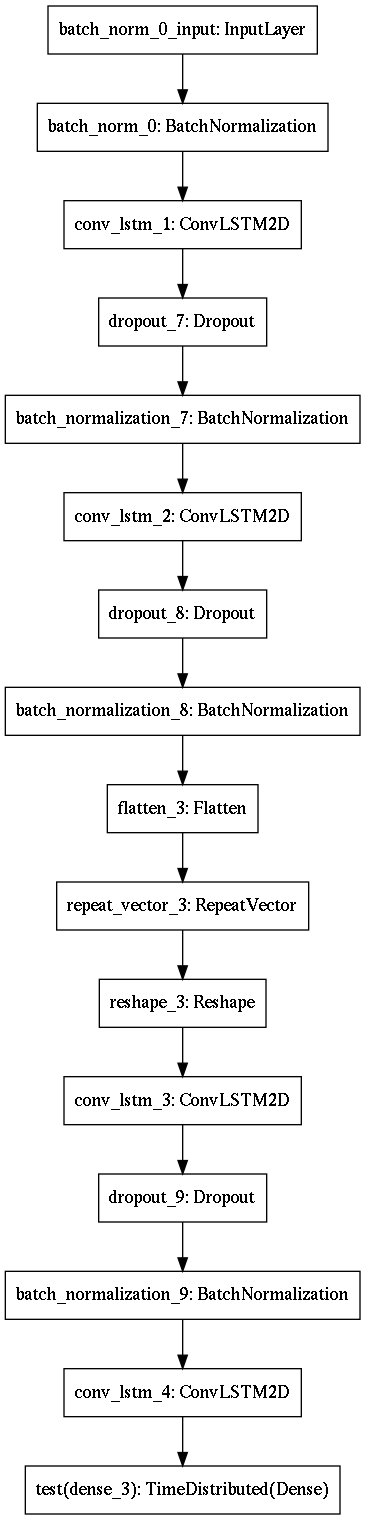

In [19]:

#  chanel first == so in encoder 3, in decoder 5 ( position
# input_bus.shape[0],

(3332, 30, 1, 375, 1)
in_dt = 30
unit1 = 64
unit2 = 32
kernel1 = 5
kernel2 = 2

def model_creator(filter1,filter2,kernel1,kernel2,dropout):
    model = Sequential([
        BatchNormalization(name = 'batch_norm_0', input_shape = (in_dt,input_bus.shape[2],input_bus.shape[3],input_bus.shape[4])), 


        ConvLSTM2D(name ='conv_lstm_1',filters=filter1, kernel_size=(kernel1, 1),stateful=False
                           , padding='same', return_sequences=True,data_format  ="channels_first"),
        Dropout(dropout),

        BatchNormalization(),

        ConvLSTM2D(name ='conv_lstm_2',filters=filter2, kernel_size=(kernel2, 1),stateful=False
                   ,data_format  ="channels_first"
                             ,padding='same', return_sequences=False),

        Dropout(dropout),

        BatchNormalization(),


        Flatten(),

        RepeatVector(out_dt),

        Reshape((out_dt,output_bus.shape[2],1,filter2)),


        ConvLSTM2D(name ='conv_lstm_3',filters=filter2,  kernel_size=(kernel2, 1),stateful=False
                            , padding='same', return_sequences=True),
        Dropout(dropout),
        BatchNormalization(),

        ConvLSTM2D(name ='conv_lstm_4',
                              filters = filter1, kernel_size = (kernel1, 1),stateful=False, 
                              padding='same',
                              return_sequences = True),
    #    Reshape((10,202472)) ,           
#    
#    TimeDistributed(Dense(out.shape[2]*20)),
##    
#    TimeDistributed(Dense(32,)),
#    
    TimeDistributed(Dense(1,activation = "sigmoid"), name='test'),


    
    
    ])
    return model
    del(model)
def fit_with(unit1,unit2,kernel1,kernel2, dropout_rate):

    model = model_creator(unit1,unit2,kernel1,kernel2,dropout_rate)

    model.compile(loss=kl.mean_absolute_error, optimizer = 'adam')
    
    hist = model.fit()
    
    del(model,hist)